# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portuguese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pmarketing_data) for more information on the data and features.



# Setup the Environment

In [13]:
# TESTING ONLY REMOVE BEFORE SUBMISSION
!rm -rf output/ logs/ sample_data/

In [14]:
# Core Python Libraries
import os
import time
import warnings
from datetime import datetime
from typing import Optional

# Data Processing Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Logging Configuration
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Scikit-learn Core
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_auc_score
)

from sklearn.utils import resample
from tabulate import tabulate


# Imbalanced Learning
from imblearn.over_sampling import SMOTE

# Warnings and Exceptions
from sklearn.exceptions import ConvergenceWarning

# Environment Setup

In [15]:
def setup_logging(name, log_dir="logs"):
    """
    Sets up a logger with both console and file handlers.

    1. Clears all existing logging handlers.
    2. Checks if the specified log directory exists; if not, creates it.
    3. Creates a log file named with the format YYMMDDHHMMSS-log.txt.
    4. Outputs logging information to the console.
    5. Outputs logging information to the log file.

    Args:
        name (str): The name of the logger.
        log_dir (str): The directory where log files will be stored.

    Returns:
        logging.Logger: Configured logger instance.
    """
    logger = logging.getLogger(name)

    # 1. Clear all existing handlers
    if logger.hasHandlers():
        logger.handlers.clear()

    logger.setLevel(logging.INFO)

    # 2. Check if log directory exists; if not, create it
    os.makedirs(log_dir, exist_ok=True)

    # 3. Create a log file with the format YYMMDDHHMMSS-log.txt
    timestamp = datetime.now().strftime("%y%m%d%H%M%S")
    log_file = os.path.join(log_dir, f"{timestamp}-log.txt")

    # Create file handler
    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setLevel(logging.INFO)

    # 4. Create console handler
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)

    # 5. Create and set formatter for both handlers
    formatter = logging.Formatter(
        '%(asctime)s | %(name)s | %(levelname)s | %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    file_handler.setFormatter(formatter)
    console_handler.setFormatter(formatter)

    # Add handlers to the logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)

    # Prevent log messages from being propagated to the root logger
    logger.propagate = False

    return logger

logger = setup_logging("Analysis")  # Use __name__ for the logger name

logger.info("This is an info message.")
logger.warning("This is a warning message.")
logger.error("This is an error message.")

2024-12-26 20:59:40 | Analysis | INFO | This is an info message.
2024-12-26 20:59:40 | Analysis | WARNING | This is a warning message.
2024-12-26 20:59:40 | Analysis | ERROR | This is an error message.


In [16]:
output_path = "output"
random_state = 42
test_size = 0.2
digits = 4

def setup_environment(logger, output_path="output"):
    """Sets up analysis environment with proper error handling."""
    try:
        # Create output directory
        os.makedirs(output_path, exist_ok=True)
        logger.info(f"Output directory configured: {output_path}")

        # Configure warnings
        warnings.filterwarnings('ignore', category=FutureWarning)
        logger.info("Future warnings suppressed")

        return True

    except Exception as e:
        logger.error(f"Error setting up environment: {e}")
        return False

environment = setup_environment(logger, output_path)

2024-12-26 20:59:40 | Analysis | INFO | Output directory configured: output
2024-12-26 20:59:40 | Analysis | INFO | Future warnings suppressed


### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

This dataset represents a collection of marketing interactions over approximately two and a half years from May 2008 to November 2010. Gathered from 17 marketing campaigns.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [17]:
def load_dataset(dataset_name, data_path, logger):
    """Loads the specified dataset from the given path and logs the success using the provided logger."""
    try:
        dataset = pd.read_csv(data_path, sep=';', engine='c')
        logger.info(f"Successfully loaded the {dataset_name} dataset")
        return dataset
    except FileNotFoundError:
        logger.error(f"Error: {dataset_name} dataset file not found at {data_path}")
        return None  # Or raise an exception
    except Exception as e:
        logger.error(f"An unexpected error occurred while loading the {dataset_name} dataset: {e}")
        return None  # Or raise an exception

dataset_name = "marketing_data"
data_path = 'data/bank-additional.csv'

marketing_data = load_dataset(dataset_name, data_path, logger)

2024-12-26 20:59:40 | Analysis | INFO | Successfully loaded the marketing_data dataset


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


### Input Variables:

#### Bank Client Data
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')

#### Related with the Last Contact of the Current Campaign
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### Other Attributes
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### Social and Economic Context Attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

#### Output variable (desired target)
21. y - has the client subscribed a term deposit? (binary: 'yes','no')

### Data Set Examination
In examining the data description, I identified most of the features could be used without any changes. However, there are a number of issues that I will address addressed when engineering features and modeling.

These include:
1. Remove duplicate values.
2. Indentify any missing, NaN, and 'unknown' values to impute or remove.
3. Use one-hot encoding for the 'contact' feature as it is binary
5. Discard the 'duration' feature as it has little importance
6. Create a days passed feature to replace the pdays feature, which I will delete.
7. The distribution of the target variable 'y' is imbalanced, which may require resampling techniques.
8. The dataset is large, which may require feature selection or dimensionality reduction techniques.
9. The dataset contains categorical features that need to be encoded.
10. The dataset contains numeric features that may require scaling.
11. The dataset contains a binary target variable that needs to be encoded.

The code in this section will assist me in addressing these issues and engineering the features.

2024-12-26 20:59:40 | Analysis | INFO | marketing_data Dataset Information

2024-12-26 20:59:40 | Analysis | INFO | Shape: (4119, 21)

2024-12-26 20:59:40 | Analysis | INFO | Number of Null Values: 0

2024-12-26 20:59:40 | Analysis | INFO | Data types:

object     11
int64       5
float64     5
Name: count, dtype: int64

2024-12-26 20:59:40 | Analysis | INFO | Descriptive Statistics:

            age     duration   campaign       pdays  previous  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed
mean  40.113620   256.788055   2.537266  960.422190  0.190337      0.084972       93.579704     -40.499102   3.621356  5166.481695
std   10.313362   254.703736   2.568159  191.922786  0.541788      1.563114        0.579349       4.594578   1.733591    73.667904
min   18.000000     0.000000   1.000000    0.000000  0.000000     -3.400000       92.201000     -50.800000   0.635000  4963.600000
max   88.000000  3643.000000  35.000000  999.000000  6.000000      1.400000       94.767

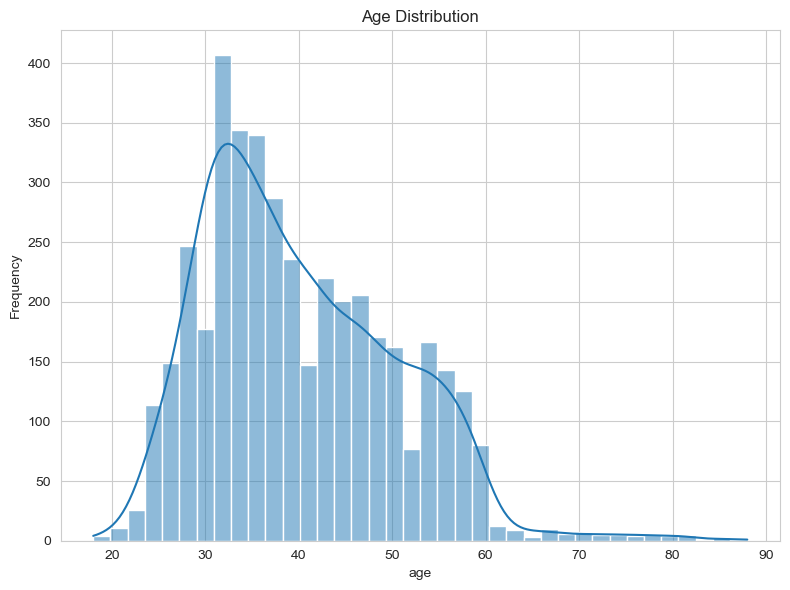

2024-12-26 20:59:40 | Analysis | INFO | Age Histogram Created and saved to output

2024-12-26 20:59:40 | Analysis | INFO | Descriptive Statistics for duration:

DURATION
{'count': 4119.0, 'mean': 256.7880553532411, 'std': 254.70373612073675, 'min': 0.0, '25%': 103.0, '50%': 181.0, '75%': 317.0, 'max': 3643.0}



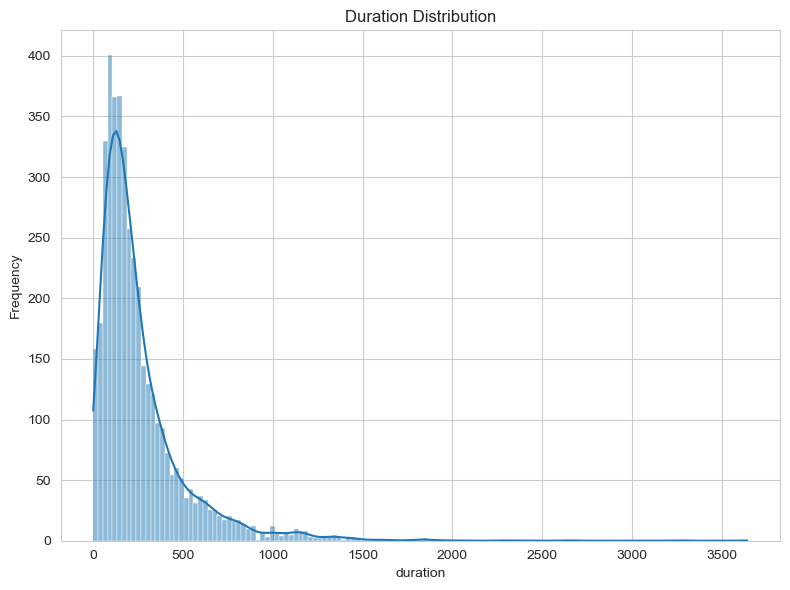

2024-12-26 20:59:40 | Analysis | INFO | Duration Histogram Created and saved to output

2024-12-26 20:59:40 | Analysis | INFO | Descriptive Statistics for campaign:

CAMPAIGN
{'count': 4119.0, 'mean': 2.537266326778344, 'std': 2.5681592375781075, 'min': 1.0, '25%': 1.0, '50%': 2.0, '75%': 3.0, 'max': 35.0}



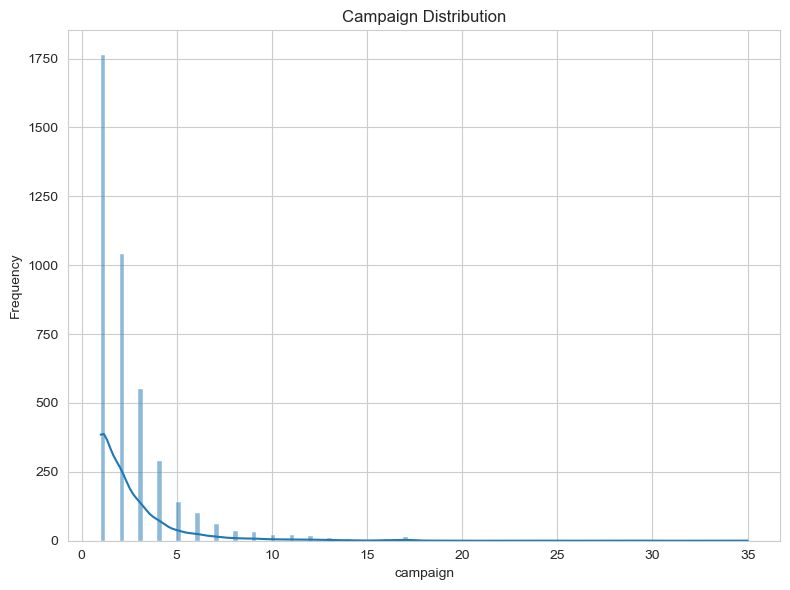

2024-12-26 20:59:41 | Analysis | INFO | Campaign Histogram Created and saved to output

2024-12-26 20:59:41 | Analysis | INFO | Descriptive Statistics for pdays:

PDAYS
{'count': 4119.0, 'mean': 960.4221898519058, 'std': 191.9227858007736, 'min': 0.0, '25%': 999.0, '50%': 999.0, '75%': 999.0, 'max': 999.0}



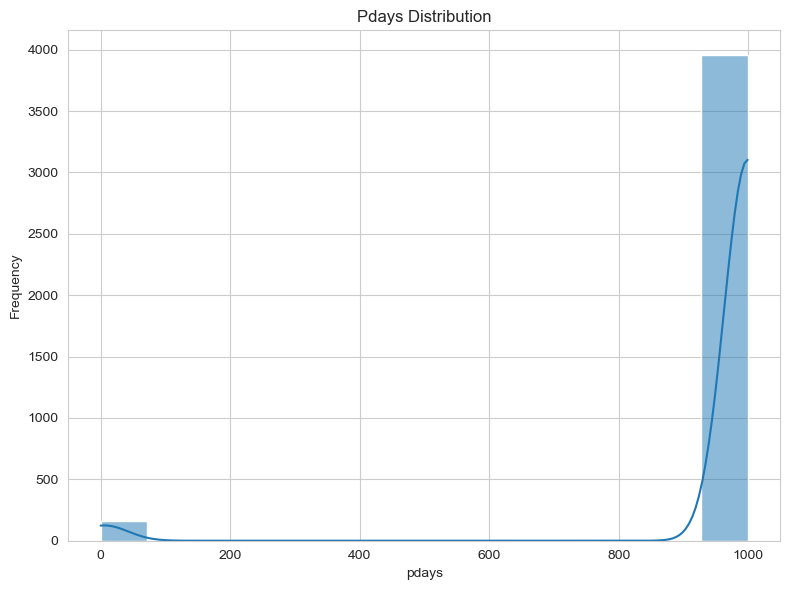

2024-12-26 20:59:41 | Analysis | INFO | Pdays Histogram Created and saved to output

2024-12-26 20:59:41 | Analysis | INFO | Descriptive Statistics for previous:

PREVIOUS
{'count': 4119.0, 'mean': 0.19033746054867687, 'std': 0.5417883234290218, 'min': 0.0, '25%': 0.0, '50%': 0.0, '75%': 0.0, 'max': 6.0}



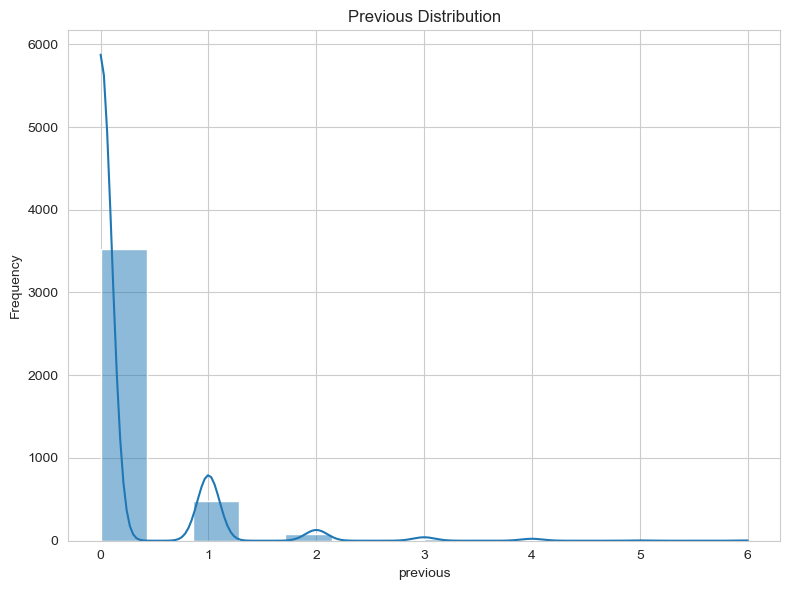

2024-12-26 20:59:41 | Analysis | INFO | Previous Histogram Created and saved to output

2024-12-26 20:59:41 | Analysis | INFO | Descriptive Statistics for emp.var.rate:

EMP.VAR.RATE
{'count': 4119.0, 'mean': 0.08497208060208788, 'std': 1.5631144559116605, 'min': -3.4, '25%': -1.8, '50%': 1.1, '75%': 1.4, 'max': 1.4}



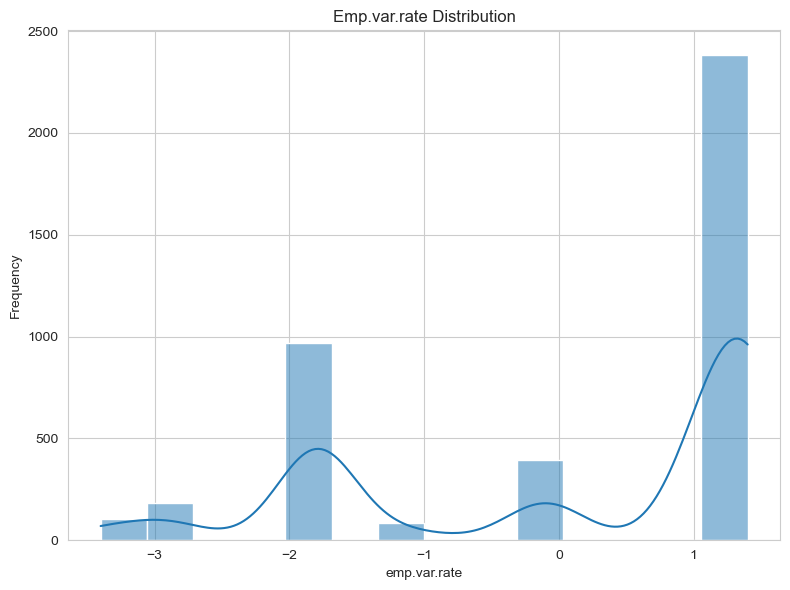

2024-12-26 20:59:41 | Analysis | INFO | Emp.var.rate Histogram Created and saved to output

2024-12-26 20:59:41 | Analysis | INFO | Descriptive Statistics for cons.price.idx:

CONS.PRICE.IDX
{'count': 4119.0, 'mean': 93.57970429715951, 'std': 0.5793488049889657, 'min': 92.201, '25%': 93.075, '50%': 93.749, '75%': 93.994, 'max': 94.767}



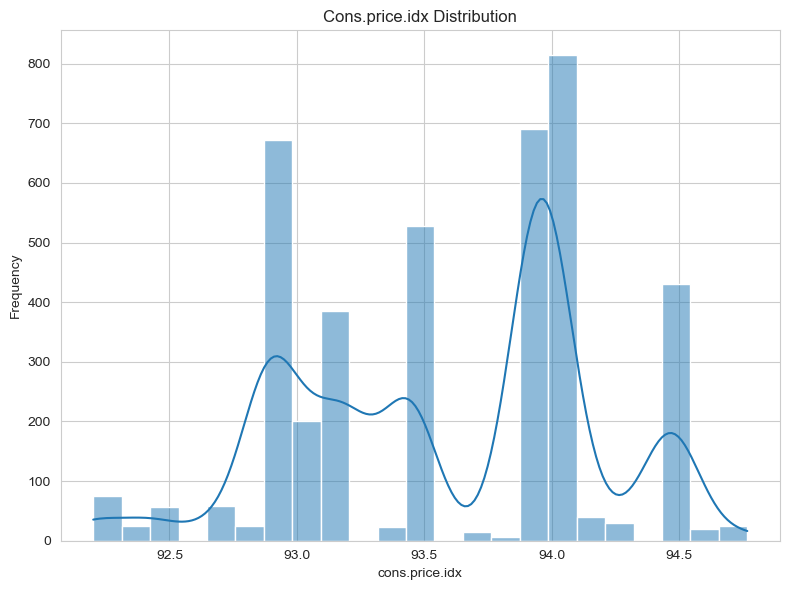

2024-12-26 20:59:41 | Analysis | INFO | Cons.price.idx Histogram Created and saved to output

2024-12-26 20:59:41 | Analysis | INFO | Descriptive Statistics for cons.conf.idx:

CONS.CONF.IDX
{'count': 4119.0, 'mean': -40.49910172371935, 'std': 4.594577506837506, 'min': -50.8, '25%': -42.7, '50%': -41.8, '75%': -36.4, 'max': -26.9}



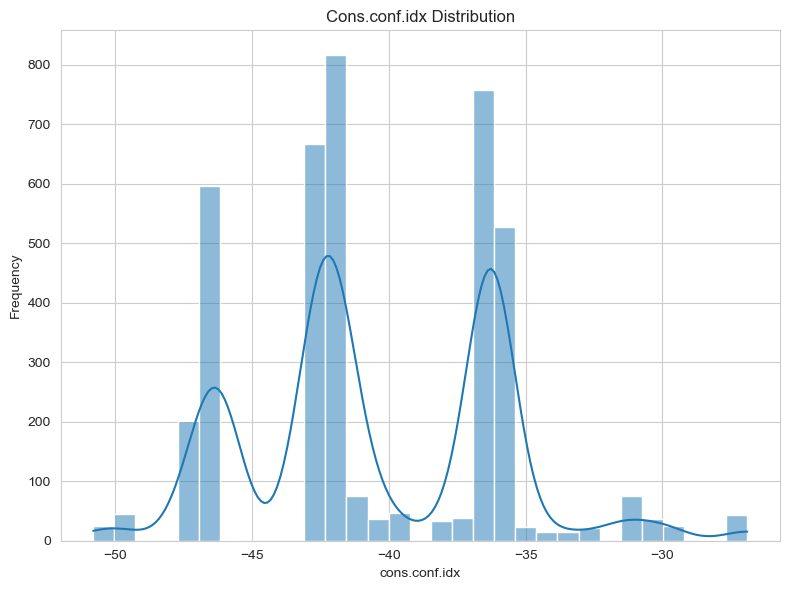

2024-12-26 20:59:42 | Analysis | INFO | Cons.conf.idx Histogram Created and saved to output

2024-12-26 20:59:42 | Analysis | INFO | Descriptive Statistics for euribor3m:

EURIBOR3M
{'count': 4119.0, 'mean': 3.621355668851663, 'std': 1.7335912227013601, 'min': 0.635, '25%': 1.334, '50%': 4.857, '75%': 4.961, 'max': 5.045}



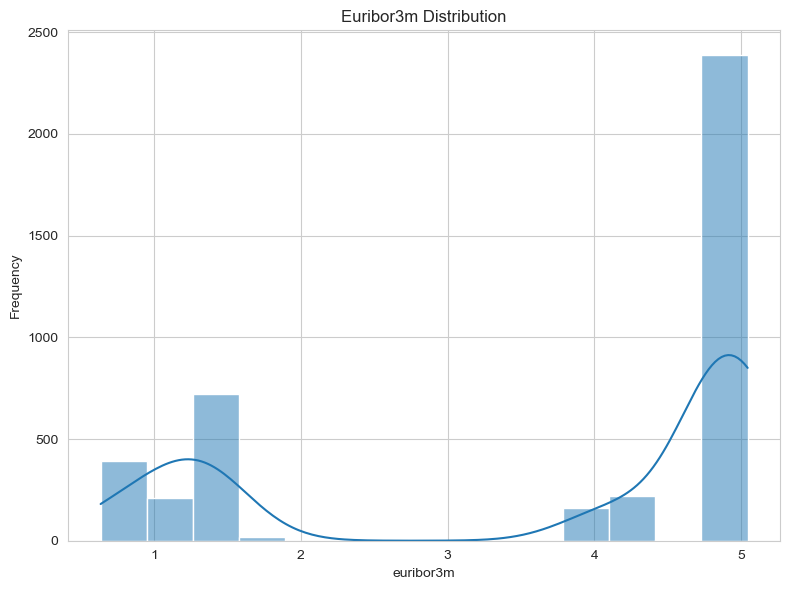

2024-12-26 20:59:42 | Analysis | INFO | Euribor3m Histogram Created and saved to output

2024-12-26 20:59:42 | Analysis | INFO | Descriptive Statistics for nr.employed:

NR.EMPLOYED
{'count': 4119.0, 'mean': 5166.481694586065, 'std': 73.66790355721277, 'min': 4963.6, '25%': 5099.1, '50%': 5191.0, '75%': 5228.1, 'max': 5228.1}



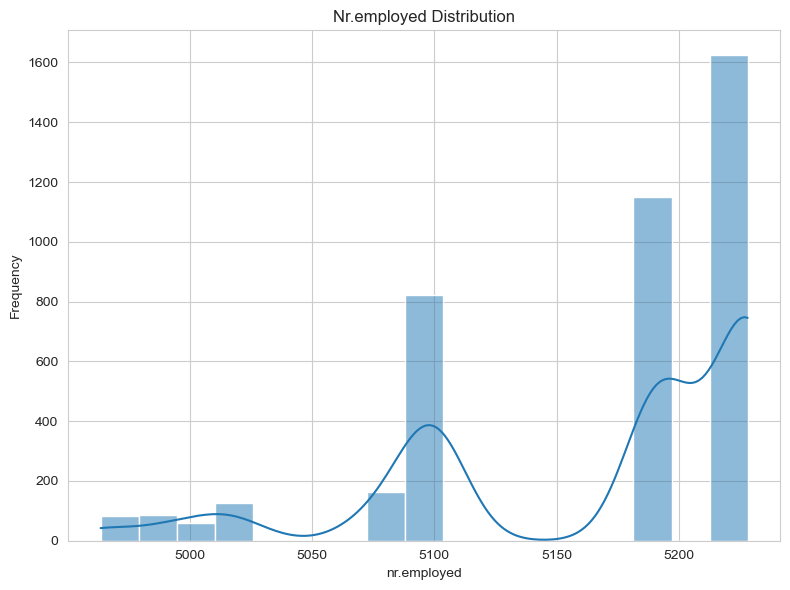

2024-12-26 20:59:42 | Analysis | INFO | Nr.employed Histogram Created and saved to output

2024-12-26 20:59:42 | Analysis | INFO | Distribution for job:

JOB
               Count  Percentage
job                             
admin.          1012       24.57
blue-collar      884       21.46
technician       691       16.78
services         393        9.54
management       324        7.87
retired          166        4.03
self-employed    159        3.86
entrepreneur     148        3.59
unemployed       111        2.69
housemaid        110        2.67
student           82        1.99
unknown           39        0.95



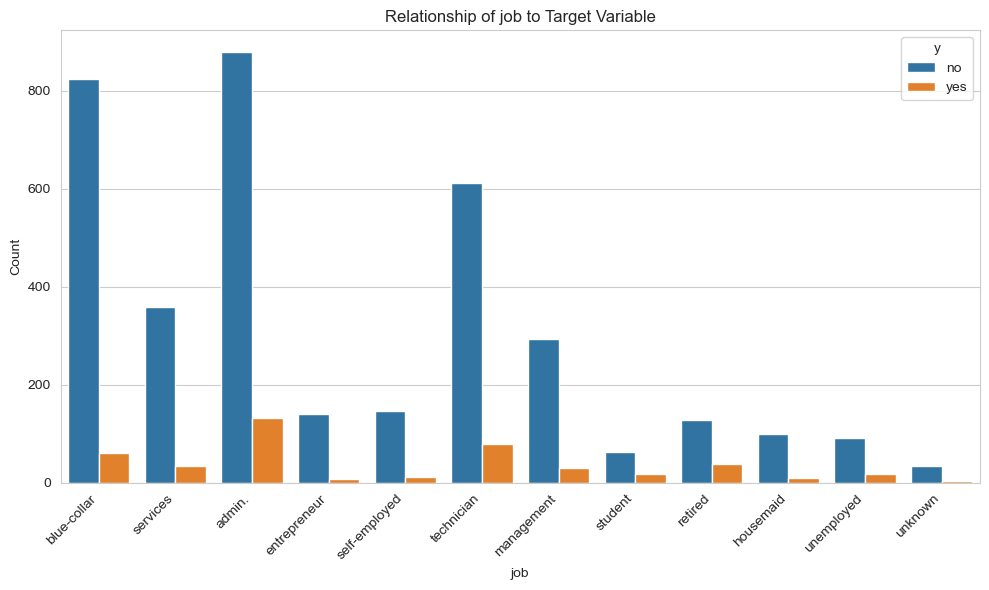

2024-12-26 20:59:42 | Analysis | INFO | Relationship plot for job and target variable created and saved to output

2024-12-26 20:59:42 | Analysis | INFO | Distribution for marital:

MARITAL
          Count  Percentage
marital                    
married    2509       60.91
single     1153       27.99
divorced    446       10.83
unknown      11        0.27



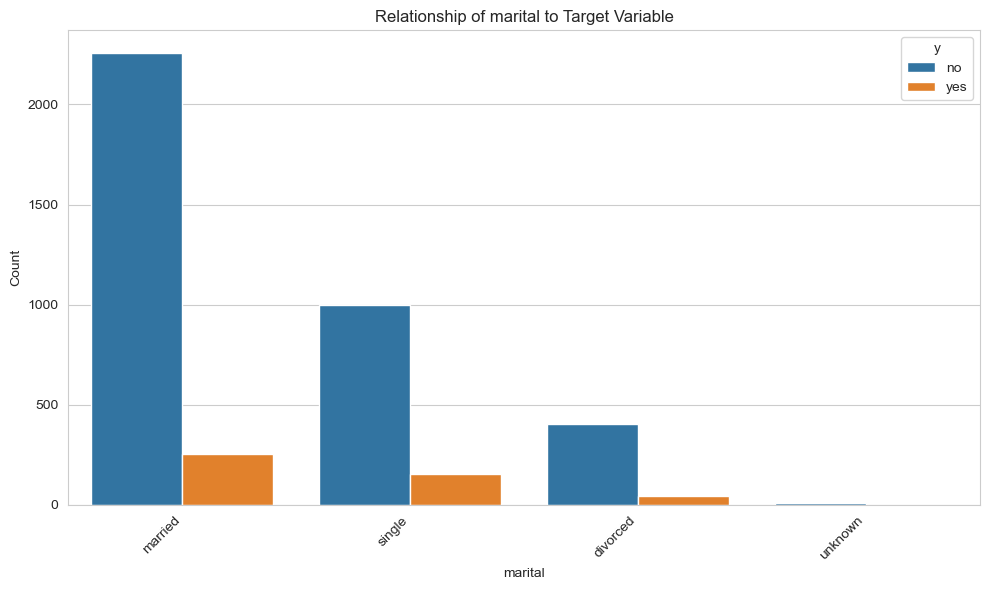

2024-12-26 20:59:42 | Analysis | INFO | Relationship plot for marital and target variable created and saved to output

2024-12-26 20:59:42 | Analysis | INFO | Distribution for education:

EDUCATION
                     Count  Percentage
education                             
university.degree     1264       30.69
high.school            921       22.36
basic.9y               574       13.94
professional.course    535       12.99
basic.4y               429       10.42
basic.6y               228        5.54
unknown                167        4.05
illiterate               1        0.02



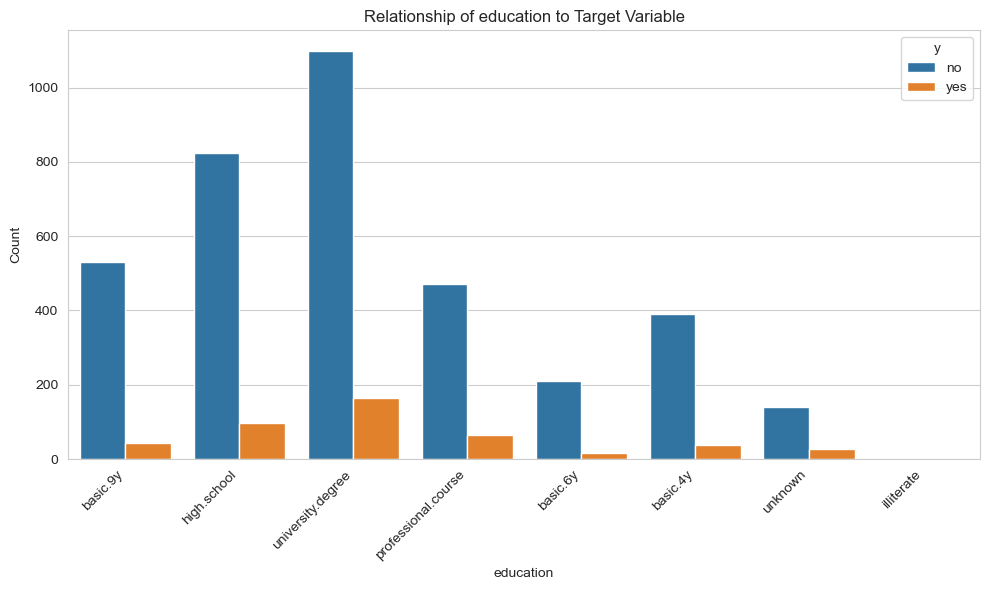

2024-12-26 20:59:42 | Analysis | INFO | Relationship plot for education and target variable created and saved to output

2024-12-26 20:59:42 | Analysis | INFO | Distribution for default:

DEFAULT
         Count  Percentage
default                   
no        3315       80.48
unknown    803       19.50
yes          1        0.02



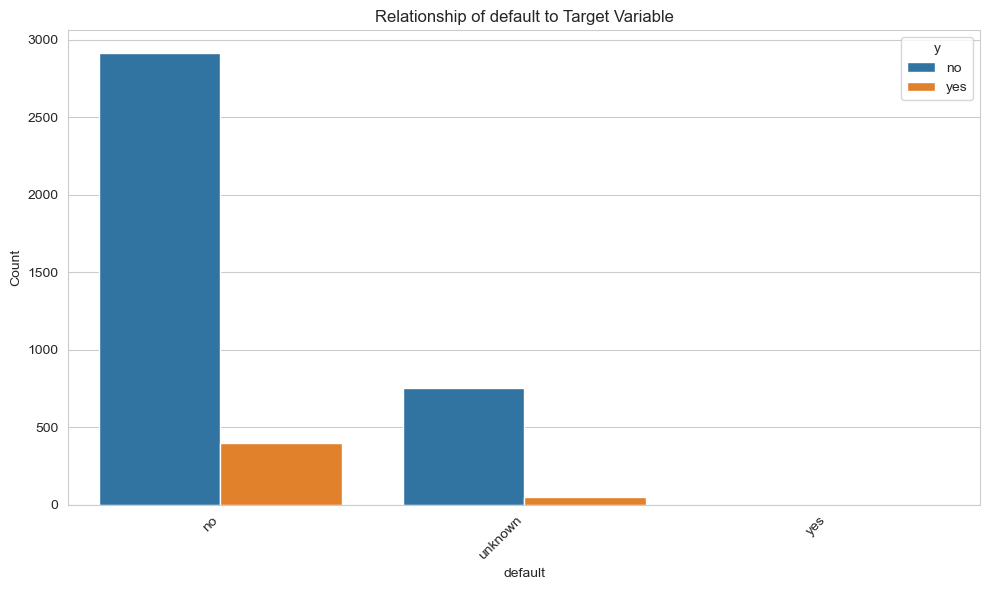

2024-12-26 20:59:42 | Analysis | INFO | Relationship plot for default and target variable created and saved to output

2024-12-26 20:59:42 | Analysis | INFO | Distribution for housing:

HOUSING
         Count  Percentage
housing                   
yes       2175       52.80
no        1839       44.65
unknown    105        2.55



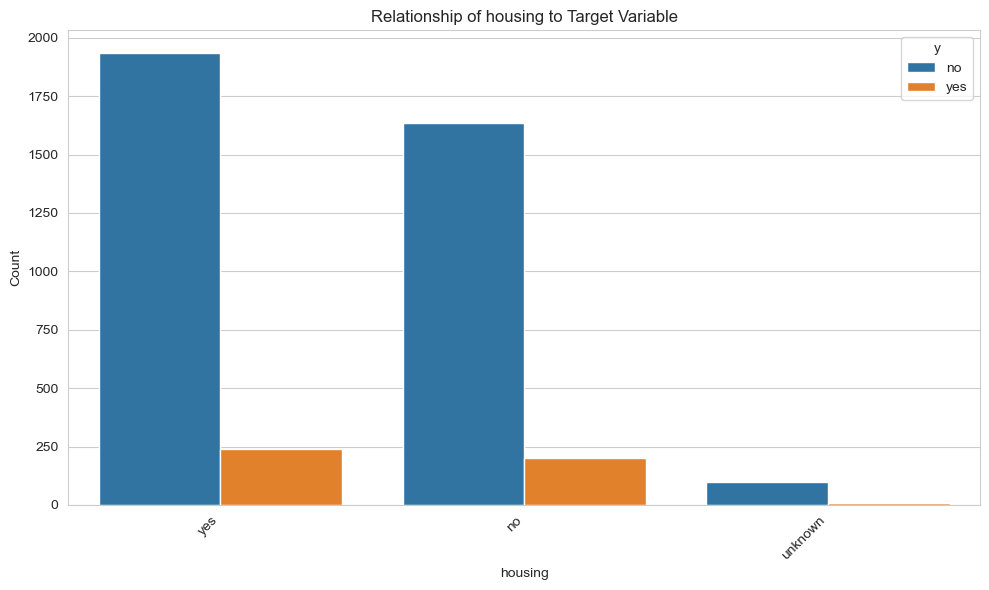

2024-12-26 20:59:43 | Analysis | INFO | Relationship plot for housing and target variable created and saved to output

2024-12-26 20:59:43 | Analysis | INFO | Distribution for loan:

LOAN
         Count  Percentage
loan                      
no        3349       81.31
yes        665       16.14
unknown    105        2.55



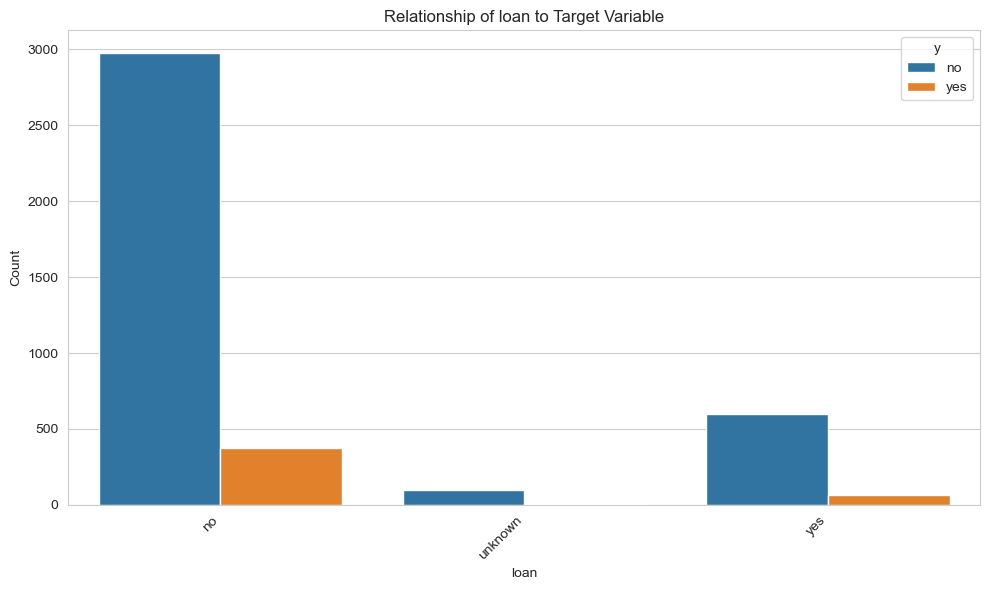

2024-12-26 20:59:43 | Analysis | INFO | Relationship plot for loan and target variable created and saved to output

2024-12-26 20:59:43 | Analysis | INFO | Distribution for contact:

CONTACT
           Count  Percentage
contact                     
cellular    2652       64.38
telephone   1467       35.62



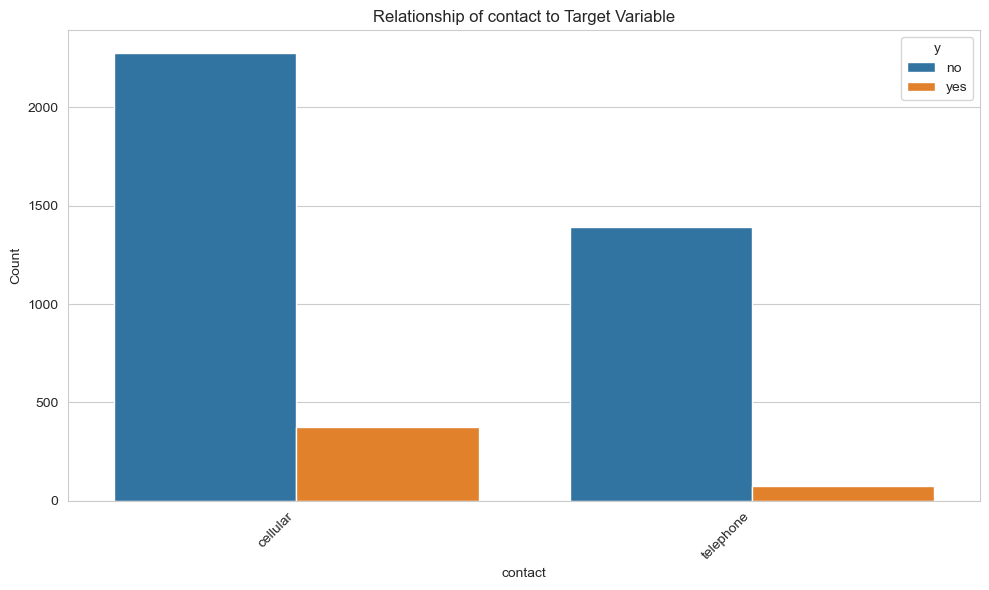

2024-12-26 20:59:43 | Analysis | INFO | Relationship plot for contact and target variable created and saved to output

2024-12-26 20:59:43 | Analysis | INFO | Distribution for month:

MONTH
       Count  Percentage
month                   
may     1378       33.45
jul      711       17.26
aug      636       15.44
jun      530       12.87
nov      446       10.83
apr      215        5.22
oct       69        1.68
sep       64        1.55
mar       48        1.17
dec       22        0.53

2024-12-26 20:59:43,231 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-26 20:59:43,234 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


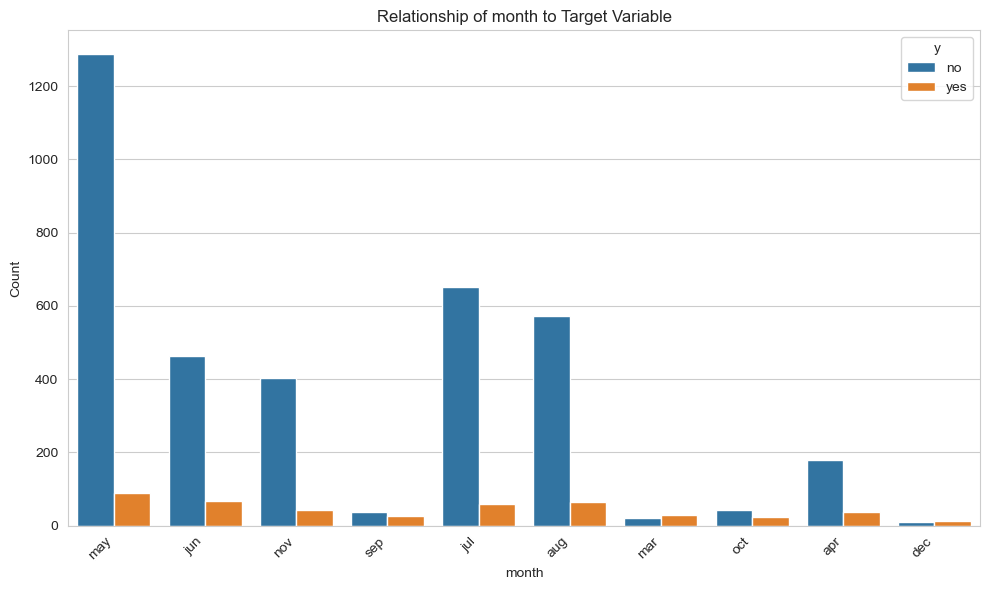

2024-12-26 20:59:43 | Analysis | INFO | Relationship plot for month and target variable created and saved to output

2024-12-26 20:59:43 | Analysis | INFO | Distribution for day_of_week:

DAY_OF_WEEK
             Count  Percentage
day_of_week                   
thu            860       20.88
mon            855       20.76
tue            841       20.42
wed            795       19.30
fri            768       18.65

2024-12-26 20:59:43,357 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-26 20:59:43,360 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


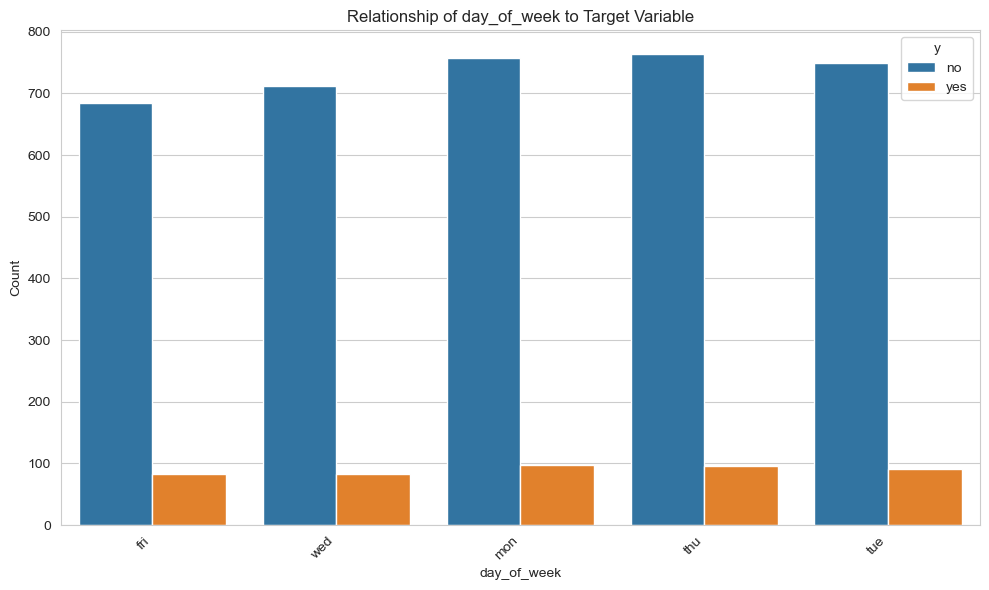

2024-12-26 20:59:43 | Analysis | INFO | Relationship plot for day_of_week and target variable created and saved to output

2024-12-26 20:59:43 | Analysis | INFO | Distribution for poutcome:

POUTCOME
             Count  Percentage
poutcome                      
nonexistent   3523       85.53
failure        454       11.02
success        142        3.45



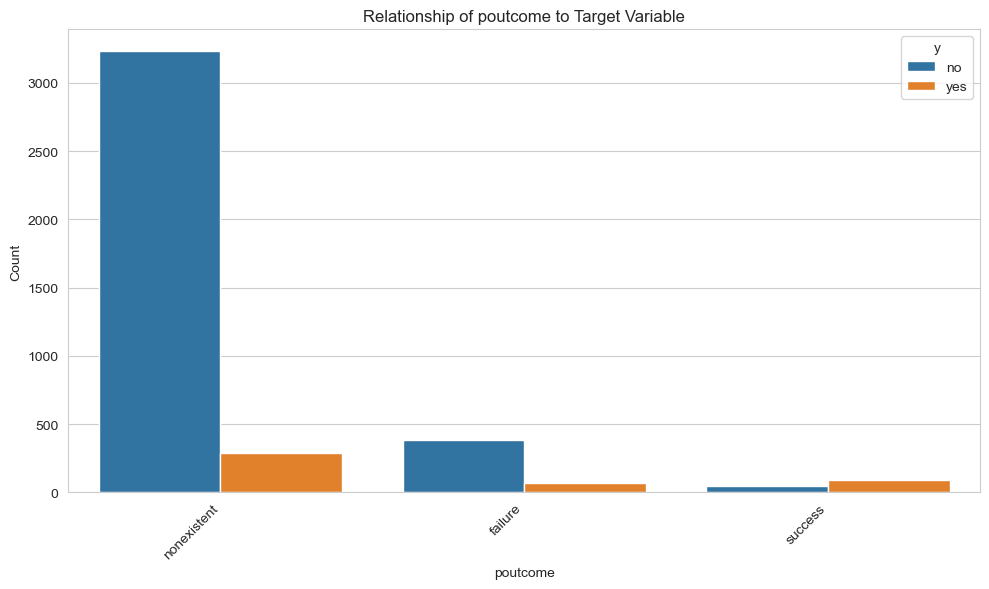

2024-12-26 20:59:43 | Analysis | INFO | Relationship plot for poutcome and target variable created and saved to output



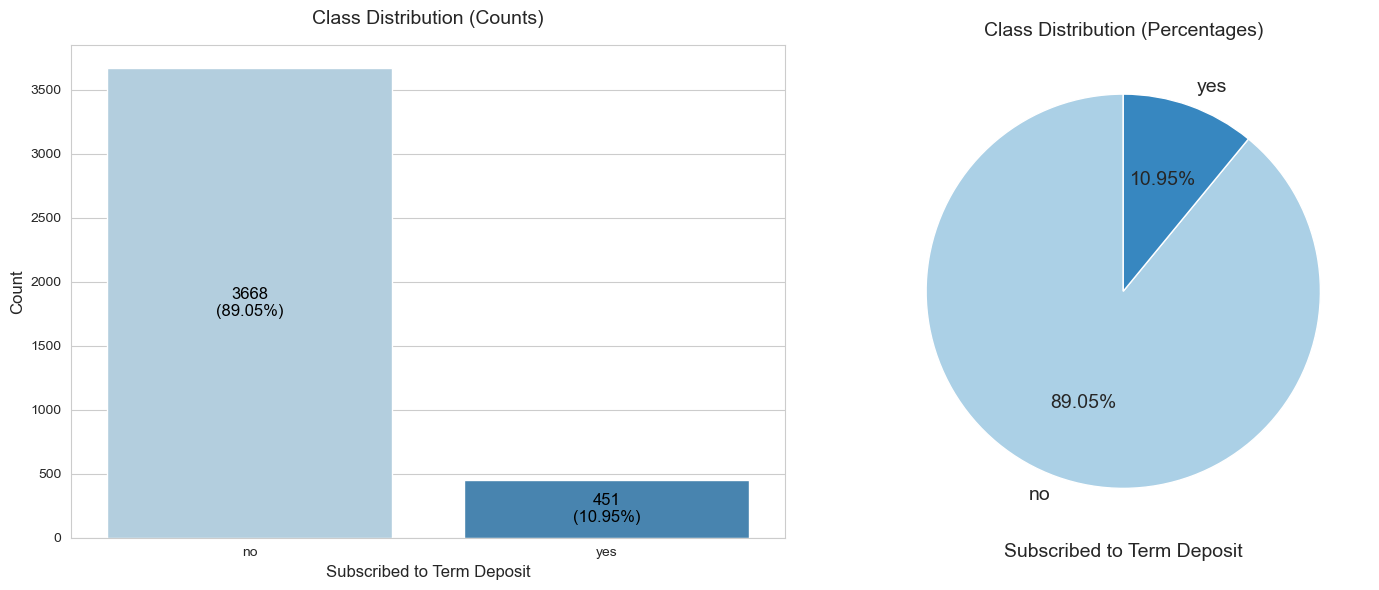

2024-12-26 20:59:43 | Analysis | INFO | Target variable analysis generated and saved to output directory.

2024-12-26 20:59:43 | Analysis | INFO | Correlation matrix calculated.



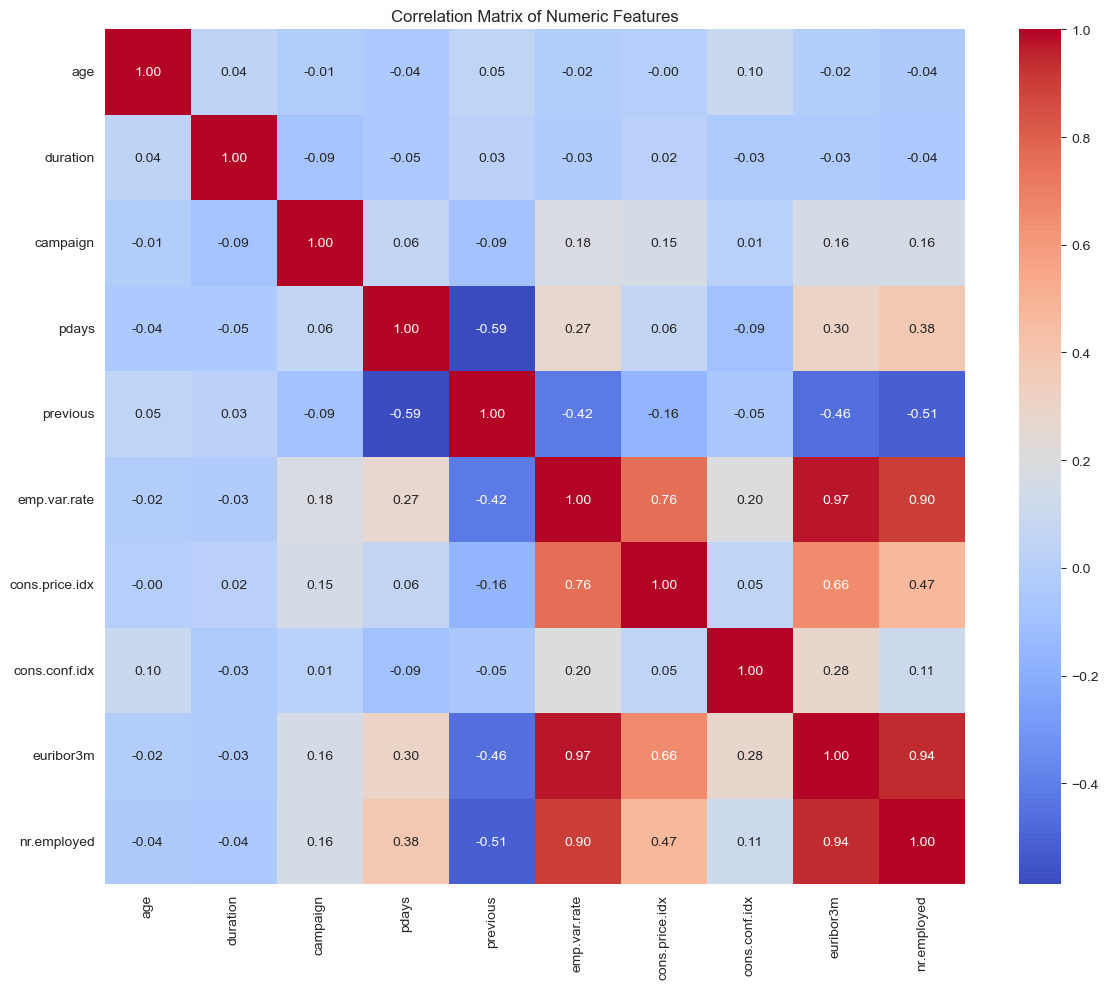

2024-12-26 20:59:43 | Analysis | INFO | Correlation matrix generated and saved to output directory.



In [18]:
# Function to log dataset information
def log_dataset_info(logger, data, name='dataset'):
    """Logs dataset information: shape, null values, data types, descriptive statistics, and random records."""
    logger.info(f"{name} Dataset Information\n")
    logger.info(f"Shape: {data.shape}\n")
    logger.info(f"Number of Null Values: {data.isnull().sum().sum()}\n")
    logger.info(f"Data types:\n\n{data.dtypes.value_counts()}\n")
    logger.info(f"Descriptive Statistics:\n\n{data.describe().loc[['mean', 'std', 'min', 'max']].to_string().replace('/', ' ')}\n")
    logger.info(f"Five Random Records:\n\n{data.sample(5).to_string().replace('/', ' ')}\n")

# Function to analyze numerical features
def analyze_numerical_features(logger, dataframe, output_path='output'):
    """Analyzes and visualizes the distributions of numerical features using histograms."""
    numeric_features = dataframe.select_dtypes(include=['number']).columns.tolist()

    summaries = {}
    for feature in numeric_features:
        summary = dataframe[feature].describe().to_dict()
        summaries[feature] = summary

        logger.info(f"Descriptive Statistics for {feature}:\n\n{feature.upper()}\n{summary}\n")

        plt.figure(figsize=(8, 6))
        sns.histplot(dataframe[feature], kde=True)
        plt.title(f'{feature.capitalize()} Distribution')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, f'num_{feature}_distribution.png'))
        plt.show()
        plt.close()
        logger.info(f"{feature.capitalize()} Histogram Created and saved to {output_path}\n")

    return summaries, numeric_features

# Function to analyze and visualize categorical features
def analyze_and_visualize_categorical_features(logger, dataframe, numeric_features, target_column='y', output_path='output'):
    """Analyzes and visualizes categorical features using count plots and summary tables."""
    categorical_features = dataframe.select_dtypes(include=['object', 'category']).columns.tolist()
    # Exclude target_column if it's categorical
    categorical_features_without_unknown = [f for f in categorical_features if f != target_column]

    summaries = {}
    for feature in categorical_features_without_unknown:
        counts = dataframe[feature].value_counts()
        percentages = dataframe[feature].value_counts(normalize=True) * 100
        summary = pd.DataFrame({
            'Count': counts,
            'Percentage': percentages.round(2)
        }).sort_values(by='Count', ascending=False)
        summaries[feature] = summary
        logger.info(f"Distribution for {feature}:\n\n{feature.upper()}\n{summary.to_string()}\n")

        try:
            plt.figure(figsize=(10, 6))
            sns.countplot(x=feature, hue=target_column, data=dataframe)
            plt.title(f'Relationship of {feature} to Target Variable')
            plt.xlabel(feature)
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(os.path.join(output_path, f'relationship_{feature}_target.png'))
            plt.show()
            plt.close()
            logger.info(f"Relationship plot for {feature} and target variable created and saved to {output_path}\n")
        except (TypeError, ValueError) as e:
            problematic_categories = dataframe[feature][
                pd.to_numeric(dataframe[feature], errors='coerce').isna()
            ].unique()
            logger.warning(
                f"Error plotting '{feature}': {e}. "
                f"Problematic categories: {problematic_categories}"
            )

    return summaries, categorical_features_without_unknown

# Function to analyze target variable distribution
def analyze_target_variable(logger, dataframe, target_column='y', output_path='output'):
    """Analyzes and visualizes the distribution of the target variable using bar and pie charts."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    sns.countplot(x=target_column, data=dataframe, palette='Blues', ax=ax1)
    ax1.set_title('Class Distribution (Counts)', fontsize=14, pad=15)
    ax1.set_xlabel('Subscribed to Term Deposit', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)

    total_count = len(dataframe)
    for p in ax1.patches:
        count = int(p.get_height())
        percentage = (count / total_count) * 100
        x_position = p.get_x() + p.get_width() / 2
        y_position = p.get_height() / 2
        ax1.annotate(
            f"{count}\n({percentage:.2f}%)",
            (x_position, y_position),
            ha='center',
            va='center',
            color='black',
            fontsize=12
        )

    counts = dataframe[target_column].value_counts()
    colors = sns.color_palette('Blues', len(counts))
    ax2.pie(counts, labels=counts.index, autopct='%1.2f%%',
            colors=colors, startangle=90, textprops={'fontsize': 14})
    ax2.set_title('Class Distribution (Percentages)', fontsize=14)
    ax2.set_xlabel('Subscribed to Term Deposit', fontsize=14)

    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'class_distribution.png'))
    plt.show()
    plt.close()
    logger.info("Target variable analysis generated and saved to output directory.\n")

# Function to generate correlation matrix
def generate_correlation_matrix(logger, dataframe, numeric_features, output_path='output'):
    """
    Generates and visualizes a correlation matrix for the given DataFrame.

    Args:
        logger (logging.Logger): Logger instance for logging information.
        dataframe (pd.DataFrame): The pandas DataFrame containing the data.
        numeric_features (list): A list of numerical features to include in the matrix.
        output_path (str): The directory to save the correlation matrix plot.
    """

    # Calculate correlation matrix
    correlation_matrix = dataframe[numeric_features].corr()
    logger.info("Correlation matrix calculated.\n")

    # Visualize correlation matrix as a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numeric Features')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'correlation_matrix.png'))  # Save to output path
    plt.show()
    plt.close()

    logger.info("Correlation matrix generated and saved to output directory.\n")

# Main function to analyze the dataset
def analyze_dataset(logger, data, target_column='y', output_path='output'):
    """
    Analyzes and visualizes the dataset, including numerical and categorical features,
    and the target variable distribution.

    Args:
        logger (logging.Logger): Logger instance for logging information.
        data (pd.DataFrame): The pandas DataFrame to analyze.
        target_column (str): The name of the target column in the DataFrame.
        output_path (str): The directory to save analysis outputs.

    Returns:
        tuple: Contains numerical summaries, categorical summaries, numeric feature list,
               and categorical feature list.
    """
    log_dataset_info(logger, data, name='marketing_data')

    numerical_summaries, numeric_features = analyze_numerical_features(logger, data, output_path)
    categorical_summaries, categorical_features = analyze_and_visualize_categorical_features(
        logger, data, numeric_features, target_column, output_path=output_path
    )
    analyze_target_variable(logger, data, target_column, output_path)
    generate_correlation_matrix(logger, data, numeric_features, output_path=output_path)

    return numerical_summaries, categorical_summaries, numeric_features, categorical_features

numerical_summaries, categorical_summaries, numeric_features, categorical_features = analyze_dataset(
            logger, marketing_data, target_column='y', output_path=output_path
        )

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The primary objective of this predictive modeling project is to optimize bank marketing campaigns through machine learning. Based on the data showing an imbalanced distribution (88.73% no, 11.27% yes), we aim to develop a model that can accurately predict which customers are likely to subscribe to a term deposit. By identifying potential subscribers, the bank can focus its marketing efforts on these individuals, thereby increasing the efficiency of its campaigns and maximizing the return on investment. The model will be evaluated based on metrics such as accuracy, precision, recall, and F1 score to ensure its effectiveness in identifying subscribers while minimizing false positives and false negatives.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [19]:
# Separate majority and minority classes
df_majority = marketing_data[marketing_data.y == 'no']
df_minority = marketing_data[marketing_data.y == 'yes']

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=random_state) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Separate features and target variable again after resampling
#X = df_upsampled.drop(columns=['y', 'y_encoded'])
X = df_upsampled.drop(columns=['y'])
y = df_upsampled['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Encode categorical variables and scale numeric features
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

# Fit and transform the data
X_transformed = preprocessor.fit_transform(X)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [20]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=test_size, random_state=random_state, stratify=y)

# Display the shapes of the transformed datasets
X_train.shape, X_test.shape

logger.info(f"X_train shape: {X_train.shape}")
logger.info(f"X_test shape: {X_test.shape}")
logger.info(f"y_train shape: {y_train.shape}")
logger.info(f"y_test shape: {y_test.shape}")

2024-12-26 20:59:44 | Analysis | INFO | X_train shape: (5868, 53)
2024-12-26 20:59:44 | Analysis | INFO | X_test shape: (1468, 53)
2024-12-26 20:59:44 | Analysis | INFO | y_train shape: (5868,)
2024-12-26 20:59:44 | Analysis | INFO | y_test shape: (1468,)


### Problem 7: A Baseline Model (Dummy Classifier)

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [21]:
# A Baseline Model (Dummy Classifier)
logger.info("Creating and Dummy Classifier...\n")

dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
start_time = time.time()  # timing
dummy_clf.fit(X_train, y_train)
end_time = time.time()  # End timing

train_time_dummy = end_time - start_time  # Calculate train time

y_pred_dummy = dummy_clf.predict(X_test)  # Get predictions for Dummy Classifier

# Calculate and log baseline accuracy
baseline_accuracy = accuracy_score(y_test, y_pred_dummy)
logger.info(f"Baseline accuracy: {baseline_accuracy:.6f}")

# Generate classification report and log it in the desired format
classification_rep_str_dummy = classification_report(y_test, y_pred_dummy, digits=digits, zero_division=0)
logger.info(f"Classification Report (Dummy Classifier):\n\n{classification_rep_str_dummy}")

# Store and print results in a DataFrame
results_df = pd.DataFrame({
    "Model": ["Dummy Classifier"],
    "Train Time": [train_time_dummy],
    "Train Accuracy": [dummy_clf.score(X_train, y_train)],
    "Test Accuracy": [baseline_accuracy]
})
logger.info(f"Dummy Classifier Results:\n\n{results_df.to_string(index=False)}\n")

2024-12-26 20:59:44 | Analysis | INFO | Creating and Dummy Classifier...

2024-12-26 20:59:44 | Analysis | INFO | Baseline accuracy: 0.500000
2024-12-26 20:59:44 | Analysis | INFO | Classification Report (Dummy Classifier):

              precision    recall  f1-score   support

           0     0.5000    1.0000    0.6667       734
           1     0.0000    0.0000    0.0000       734

    accuracy                         0.5000      1468
   macro avg     0.2500    0.5000    0.3333      1468
weighted avg     0.2500    0.5000    0.3333      1468

2024-12-26 20:59:44 | Analysis | INFO | Dummy Classifier Results:

           Model  Train Time  Train Accuracy  Test Accuracy
Dummy Classifier    0.000585             0.5            0.5



### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.

#### This code generates basic models for Logistical Regression, Decision Tree, Random Forest, KNN & SVM

2024-12-26 20:59:44 | Analysis | INFO | Training Logistic Regression
2024-12-26 20:59:44 | Analysis | INFO | Logistic Regression ROC AUC: 0.9438
2024-12-26 20:59:44 | Analysis | INFO | Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       734
           1       0.88      0.88      0.88       734

    accuracy                           0.88      1468
   macro avg       0.88      0.88      0.88      1468
weighted avg       0.88      0.88      0.88      1468



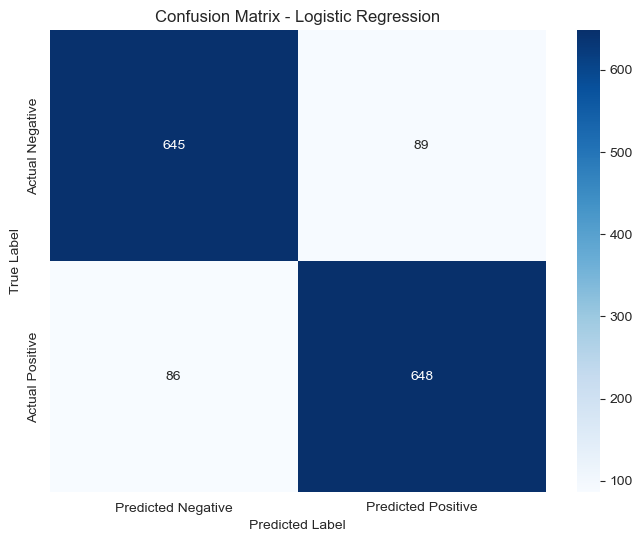

2024-12-26 20:59:44 | Analysis | INFO | Confusion matrix for Logistic Regression created and saved to output

2024-12-26 20:59:44 | Analysis | INFO | Training Decision Tree
2024-12-26 20:59:44 | Analysis | INFO | Decision Tree ROC AUC: 0.9714
2024-12-26 20:59:44 | Analysis | INFO | Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       734
           1       0.95      1.00      0.97       734

    accuracy                           0.97      1468
   macro avg       0.97      0.97      0.97      1468
weighted avg       0.97      0.97      0.97      1468



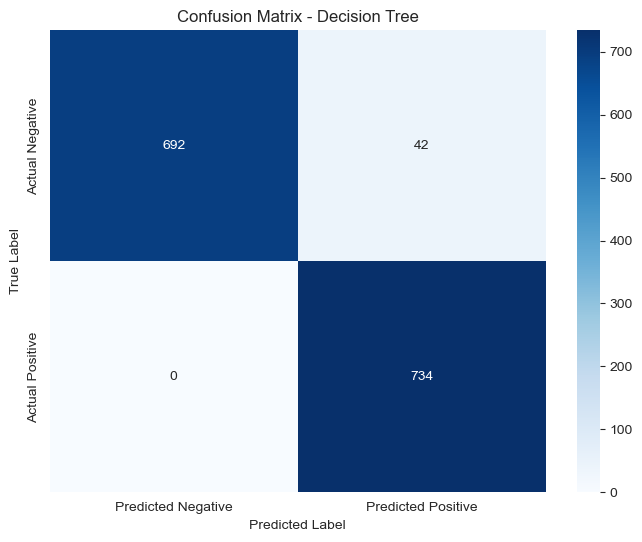

2024-12-26 20:59:44 | Analysis | INFO | Confusion matrix for Decision Tree created and saved to output

2024-12-26 20:59:44 | Analysis | INFO | Training KNN
2024-12-26 20:59:44 | Analysis | INFO | KNN ROC AUC: 0.9619
2024-12-26 20:59:44 | Analysis | INFO | KNN Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       734
           1       0.85      0.98      0.91       734

    accuracy                           0.90      1468
   macro avg       0.91      0.90      0.90      1468
weighted avg       0.91      0.90      0.90      1468



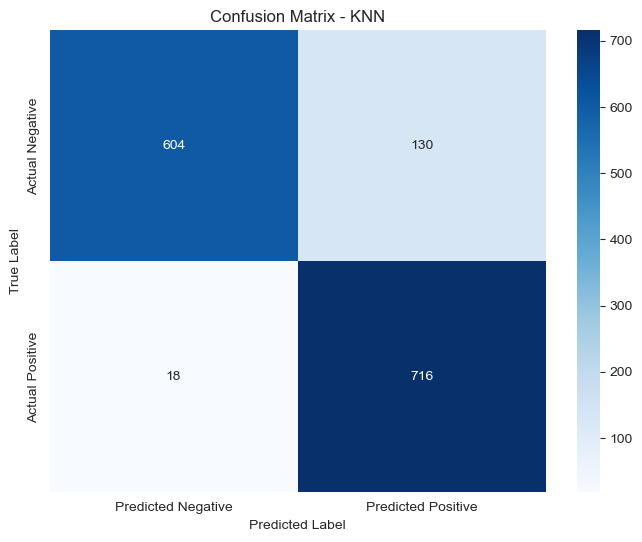

2024-12-26 20:59:44 | Analysis | INFO | Confusion matrix for KNN created and saved to output

2024-12-26 20:59:44 | Analysis | INFO | Training SVM
2024-12-26 20:59:47 | Analysis | INFO | SVM ROC AUC: 0.9764
2024-12-26 20:59:47 | Analysis | INFO | SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       734
           1       0.91      0.97      0.94       734

    accuracy                           0.94      1468
   macro avg       0.94      0.94      0.94      1468
weighted avg       0.94      0.94      0.94      1468



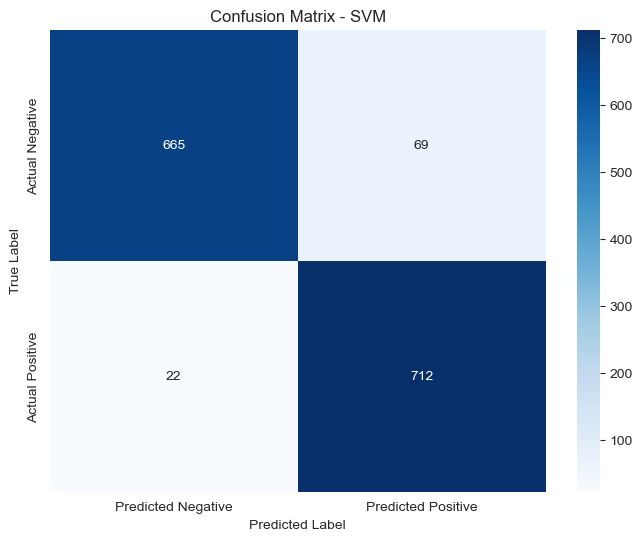

2024-12-26 20:59:47 | Analysis | INFO | Confusion matrix for SVM created and saved to output



In [22]:


def create_model_pipeline(model_name='Logistic Regression', random_state=random_state):
    """Creates a model instance based on name."""
    models = {
        'Logistic Regression': LogisticRegression(random_state=random_state),
        'Decision Tree': DecisionTreeClassifier(random_state=random_state),
        'SVM': SVC(probability=True, random_state=random_state),
        'KNN': KNeighborsClassifier()
    }

    if model_name not in models:
        raise ValueError(f"Unsupported model: {model_name}")

    return models[model_name]

def create_model_confusion_matrices(y_true, y_pred, model_name, logger):
    """Creates and saves a confusion matrix plot."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])  # Keyword arguments first
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig(os.path.join(output_path, f"confusion_matrix_{model_name}.png"))  # Save to output path
    plt.show()
    plt.close()
    logger.info(f"Confusion matrix for {model_name} created and saved to {output_path}\n")


def train_model(X_train, X_test, y_train, y_test, model_name='Logistic Regression', random_state=random_state):
    """Trains and evaluates a machine learning model."""
    global logger  # Access the logger defined earlier

    model = create_model_pipeline(model_name, random_state)
    logger.info(f"Training {model_name}")

    # Convert X_train and X_test to DataFrames
    X_train = pd.DataFrame(X_train)  # Assuming original column names are lost
    X_test = pd.DataFrame(X_test)

    # Create preprocessing pipeline
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
    numerical_features = X_train.select_dtypes(include=['number']).columns

    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ])

    # Create and train pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = pipeline.predict(X_test)
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)

# Calculate ROC AUC for all models
    try:
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
        logger.info(f"{model_name} ROC AUC: {roc_auc:.4f}")
    except AttributeError:  # Handle models without predict_proba
        roc_auc = np.nan
        logger.warning(f"{model_name} does not support predict_proba. ROC AUC set to NaN.")

    logger.info(f"{model_name} Classification Report:\n{classification_report(y_test, y_pred, zero_division=0)}")

    # Generate confusion matrix
    create_model_confusion_matrices(y_test, y_pred, model_name, logger)

    return {
        'model': pipeline,
        'predictions': y_pred,
        'metrics': {
            'train_time': train_time,
            'train_accuracy': train_score,
            'test_accuracy': test_score,
            'roc_auc': roc_auc  # Include ROC AUC in metrics
        }
    }


# Create results DataFrame with expanded metrics
results_df = pd.DataFrame(columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy',
                                   'Precision', 'Recall', 'F1-Score', 'ROC AUC'])

def create_results_table(all_results, y_test):
    """Creates a formatted table of model results."""
    results = []

    for model_name, result in all_results.items():
        y_pred = result['predictions']
        metrics = result['metrics']

        results.append({
            'Model': model_name,
            'Train Time (s)': f"{metrics['train_time']:.2f}",
            'Train Acc': f"{metrics['train_accuracy']:.4f}",
            'Test Acc': f"{metrics['test_accuracy']:.4f}",
            'Precision': f"{precision_score(y_test, y_pred):.4f}",
            'Recall': f"{recall_score(y_test, y_pred):.4f}",
            'F1': f"{f1_score(y_test, y_pred):.4f}",
            'ROC AUC': f"{metrics.get('roc_auc', np.nan):.4f}"  # Get ROC AUC or NaN
        })

    results_df = pd.DataFrame(results)

    # Create formatted table
    table = tabulate(
        results_df,
        headers='keys',
        tablefmt='psql',
        floatfmt='.4f',
        numalign='right',
        stralign='left'
    )

    return table, results_df

# Train multiple models
model_names = ['Logistic Regression', 'Decision Tree', 'KNN', 'SVM']
all_results = {}

for model_name in model_names:
    all_results[model_name] = train_model(
        X_train, X_test, y_train, y_test,
        model_name=model_name,
        random_state=random_state
    )

### Problem 9: Score the Model

What is the accuracy of your model?

Training Accuracy 0.8800<br/>Testing Accuracy 0.8796

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
|-------|------------|----------------|---------------|
|       |            | .              | .             |

In [23]:
# Logistical Regression Accuracy & Stats
table, results_df = create_results_table(all_results, y_test)
logger.info(f"Comparative Results:\n{table}")

2024-12-26 20:59:47 | Analysis | INFO | Comparative Results:
+----+---------------------+------------------+-------------+------------+-------------+----------+--------+-----------+
|    | Model               |   Train Time (s) |   Train Acc |   Test Acc |   Precision |   Recall |     F1 |   ROC AUC |
|----+---------------------+------------------+-------------+------------+-------------+----------+--------+-----------|
|  0 | Logistic Regression |           0.0600 |      0.8805 |     0.8808 |      0.8792 |   0.8828 | 0.8810 |    0.9438 |
|  1 | Decision Tree       |           0.0300 |      1.0000 |     0.9714 |      0.9459 |   1.0000 | 0.9722 |    0.9714 |
|  2 | KNN                 |           0.0100 |      0.9323 |     0.8992 |      0.8463 |   0.9755 | 0.9063 |    0.9619 |
|  3 | SVM                 |           1.8900 |      0.9513 |     0.9380 |      0.9117 |   0.9700 | 0.9399 |    0.9764 |
+----+---------------------+------------------+-------------+------------+-------------+----

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [24]:
# Define a custom scoring function
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)

def train_and_tune_model(logger, model_name, X_train, y_train, X_test, y_test, param_grid, scoring=roc_auc_scorer):
    """
    Trains and tunes a model using GridSearchCV with logging.

    Args:
        logger: The logger instance.
        model_name (str): The name of the model.
        X_train, y_train: Training data.
        X_test, y_test: Testing data.
        param_grid (dict): Hyperparameter grid for tuning.
        scoring: A scoring function (default: roc_auc_scorer).

    Returns:
        dict: A dictionary containing the trained model, best parameters,
              and evaluation metrics.
    """
    logger.info(f"Starting hyperparameter tuning for {model_name}...")

    model = create_model_pipeline(model_name)  # Create model instance
    grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=5, n_jobs=-1)

    logger.info(f"Fitting {model_name} with GridSearchCV...")
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    metrics = {
        'train_accuracy': best_model.score(X_train, y_train),
        'test_accuracy': best_model.score(X_test, y_test),
        'roc_auc': roc_auc_score(y_test, y_pred),
        'best_params': grid_search.best_params_
    }

    logger.info(f"{model_name} - Best Parameters: {metrics['best_params']}")
    logger.info(f"{model_name} - Test Accuracy: {metrics['test_accuracy']}")
    logger.info(f"{model_name} - ROC AUC: {metrics['roc_auc']}\n")

    return {'model': best_model, 'metrics': metrics}

# Define hyperparameter grids for each model
# Define hyperparameter grids for each model
param_grids = {
    'Logistic Regression': [
        {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear']},
        {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'l1_ratio': [0.5, 0.7, 0.9]}
    ],
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'linear']
    }
}

# Train and tune models with logging
tuned_results = {}
for model_name in param_grids:
    tuned_results[model_name] = train_and_tune_model(
        logger, model_name, X_train, y_train, X_test, y_test, param_grids[model_name]
    )

# Train and tune models with logging and table generation
tuned_results = {}
results_data = []  # List to store results for the table

for model_name in param_grids:
    start_time = time.time()  # Record start time
    tuned_results[model_name] = train_and_tune_model(
        logger, model_name, X_train, y_train, X_test, y_test, param_grids[model_name]
    )
    end_time = time.time()  # Record end time
    train_time = end_time - start_time

    metrics = tuned_results[model_name]['metrics']
    best_model = tuned_results[model_name]['model']

    # Get predictions for additional metrics
    y_pred = best_model.predict(X_test)

    results_data.append([
        model_name,
        train_time,  # Add train time to results
        metrics['train_accuracy'],
        metrics['test_accuracy'],
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        metrics['roc_auc']
    ])

# Generate and log the table
headers = ["Model", "Train Time (s)", "Train Acc", "Test Acc", "Precision", "Recall", "F1", "ROC AUC"]
table = tabulate(results_data, headers=headers, tablefmt="psql", floatfmt=".4f")
logger.info(f"Comparative Results:\n{table}")

2024-12-26 20:59:47 | Analysis | INFO | Starting hyperparameter tuning for Logistic Regression...
2024-12-26 20:59:47 | Analysis | INFO | Fitting Logistic Regression with GridSearchCV...
/Users/mwstout/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mwstout/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mwstout/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mwstout/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mwstout/miniconda3/lib/python3.12/site-package

##### Questions